

---



## **Automaic Ticket Classification**

**Importing the necessary libraries**



In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
import re
import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

**Data Loading**





In [2]:
# #Mount the google drive which has the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:

root_path = '/content/gdrive/MyDrive/complaints-2021-05-14_08_16.json'

In [4]:
# Opening JSON file
f = open(root_path)

# returns JSON object as a dictionary
data = json.load(f)

In [5]:
df=pd.json_normalize(data)

In [6]:
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [7]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign new column names
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [9]:
# Rename columns
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [10]:
#merge the category and sub-category
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df.head()

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [11]:
#check the nan complaints
df.complaint_text.isnull().sum()

np.int64(0)

In [12]:
#check the empty string complaints
len(df[df['complaint_text']==''])

57241

In [13]:
#Assign nan in place of blanks in the complaints column
#replace empty complain with nan value
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

np.int64(57241)

In [14]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()

np.int64(0)

# **Text Preprocessing**




### **Prepare the text for topic modeling**



In [15]:
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()


In [16]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

,complaint_text
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...
10,chase card was reported on however fraudulent ...
11,on while trying to book a xxxx xxxx ticket i...
14,my grand son give me check for i deposit it in...


In [17]:
#remove stop words
stopwords = nlp.Defaults.stop_words
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)


In [18]:
# Lemmatize the complaints
df['lemma'] =  df.complaint_text.apply(lambda x: lemmatizer(x))
df.head()

,complaint_text,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card+General-purpose cr...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account+Checking account,grand son check deposit chase account fund cle...


In [19]:
#Create a dataframe
df_clean = df[['complaint_text','lemma','category']]
df_clean.head()

,complaint_text,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account


In [20]:
#extract the POS tags NN
def extract_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)


In [ ]:
#DF containing complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] =  df_clean.lemma.apply(lambda x: extract_pos_tags(x))
df_clean.head()

,complaint_text,lemma,category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund account pay mon...


# **Exploratory data analysis (EDA)**

(array([9.524e+03, 6.310e+03, 2.633e+03, 1.248e+03, 6.830e+02, 2.680e+02,
        1.230e+02, 7.800e+01, 5.500e+01, 3.800e+01, 2.900e+01, 1.200e+01,
        1.200e+01, 1.500e+01, 3.000e+00, 1.000e+01, 2.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 7.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([    0. ,   248.3,   496.6,   744.9,   993.2,  1241.5,  1489.8,
         1738.1,  1986.4,  2234.7,  2483. ,  2731.3,  2979.6,  3227.9,
         3476.2,  3724.5,  3972.8,  4221.1,  4469.4,  4717.7,  4966. ,
         5214.3,  5462.6,  5710.9,  5959.2,  6207.5,  6455.8,  6704.1,
         6952.4,  7200.7,  7449. ,  7697.3,  7945.6,  8193.9,  8442.2,
         8690.5,  893

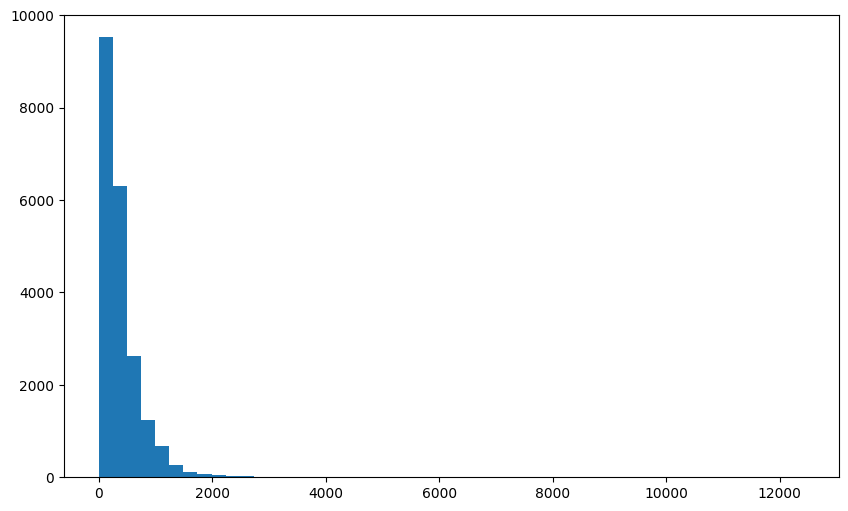

In [22]:
#visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

**Find the top 30 words by frequency among all the articles after processing the text.**

In [23]:
!pip install wordcloud

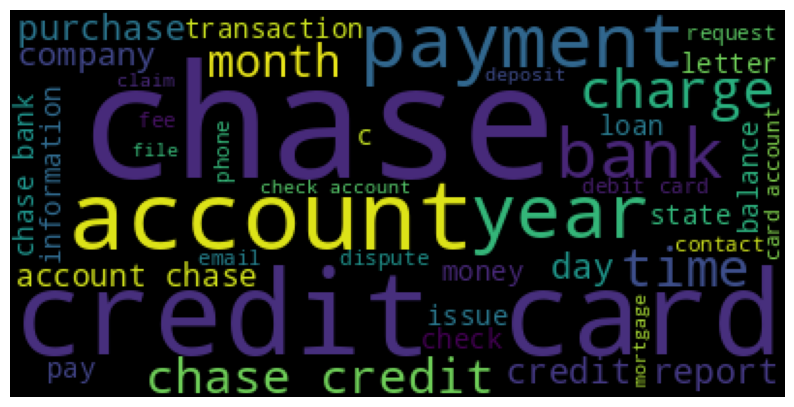

In [ ]:
#word cloud to find the top 40 words by frequency

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [25]:
#Remove -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

**Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [26]:
# top 30 unigram,bigram,trigram frequency

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]


In [27]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [28]:
#Print the top 10 words in the unigram frequency
print('Top 5 unigrams:\n')
top_30_unigrams[:5]

Top 5 unigrams:



[('chase', np.int64(58476)),
 ('account', np.int64(41834)),
 ('credit', np.int64(33528)),
 ('card', np.int64(29937)),
 ('payment', np.int64(20937))]

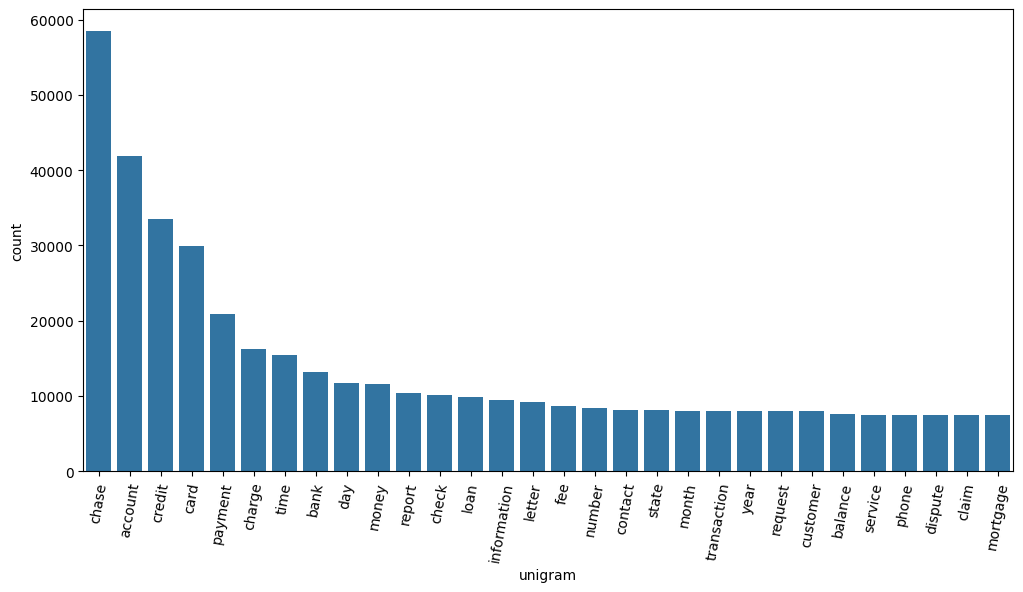

In [29]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [30]:
#top 5 words in the bigram frequency
print('Top 5 bigrams:\n')
top_30_bigrams[:5]

Top 5 bigrams:



[('credit card', np.int64(12719)),
 ('credit report', np.int64(3857)),
 ('chase credit', np.int64(3124)),
 ('customer service', np.int64(2962)),
 ('account chase', np.int64(2962))]

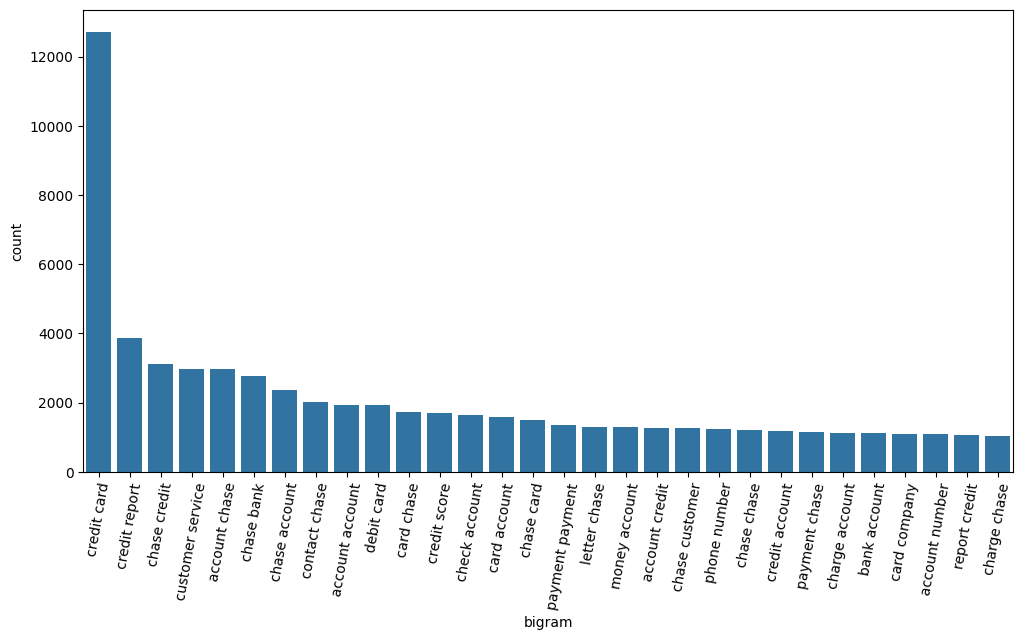

In [31]:
#top 30 words in the bigram frequency
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [32]:
#top 5 words in the trigram frequency
print('Top 5 trigrams:\n')
top_30_trigrams[:5]

Top 5 trigrams:



[('chase credit card', np.int64(2204)),
 ('credit card account', np.int64(1052)),
 ('credit card company', np.int64(981)),
 ('credit card chase', np.int64(869)),
 ('chase customer service', np.int64(618))]

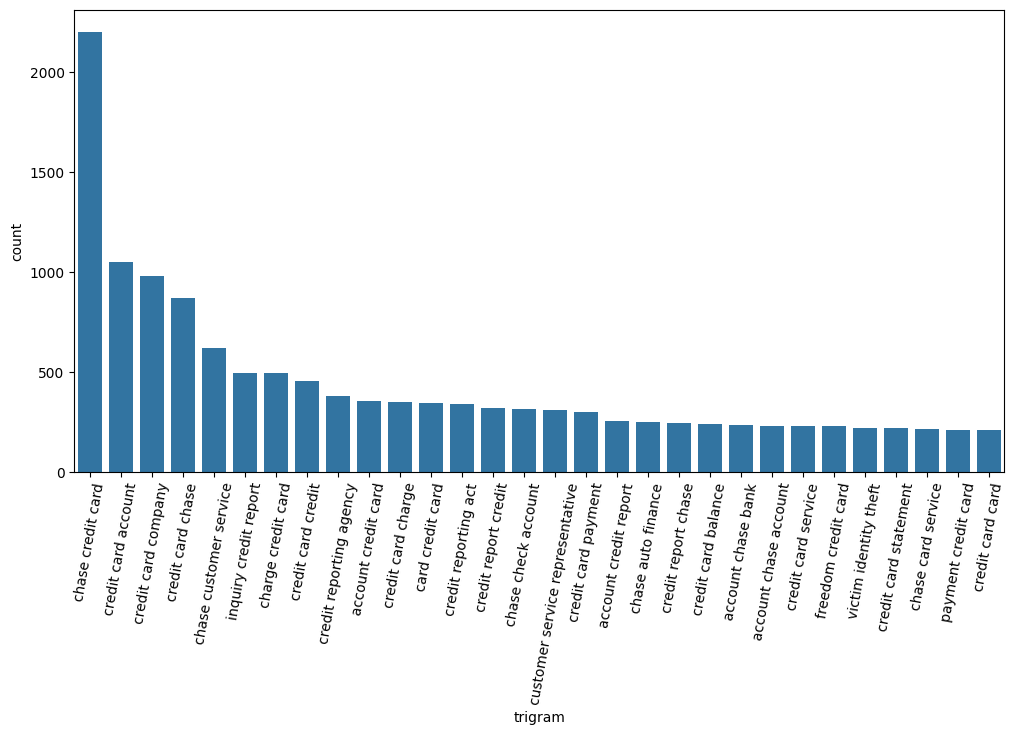

In [33]:
#top 30 words in the trigram frequency
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

In [34]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [35]:
#All masked texts has been removed
df_clean.head()

,complaint_text,lemma,category,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund account pay mon...


**Feature Extraction**





**Convert the raw texts to a matrix of TF-IDF features**



In [36]:
#initialise the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### **Create a document term matrix using fit_transform**


In [37]:
#create the Document Term Matrix
dtm = tfidf.fit_transform(df_clean.Complaint_clean)

In [38]:
len(tfidf.get_feature_names_out())

6493

In [39]:
print(tfidf.get_feature_names_out())

['aarp' 'abandonment' 'abate' ... 'zombie' 'zone' 'zoom']


**Topic Modelling**





In [40]:
from sklearn.decomposition import NMF

**Manual Topic Modeling**


In [41]:
num_topics =  5

nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [43]:
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [44]:
vocab

array(['aarp', 'abandonment', 'abate', ..., 'zombie', 'zone', 'zoom'],
      dtype=object)

In [45]:
topics

['account check money chase deposit bank fund day branch transfer number transaction business claim customer',
 'credit card report inquiry chase account score company information debt limit application letter year reporting',
 'payment balance month pay statement fee day time auto chase credit date mortgage error year',
 'charge card fee dispute chase transaction purchase merchant claim service balance fraud statement time email',
 'loan mortgage chase modification home property letter year document rate request time foreclosure sale information']

In [46]:
#topic for each complaint in terms of integer value 0,1,2,3,4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.02,0.01,0.01,0.01,0.03,4
Doc1,0.01,0.00,0.00,0.00,0.01,0
Doc2,0.00,0.05,0.00,0.00,0.00,1
Doc3,0.02,0.06,0.00,0.01,0.02,1
Doc4,0.07,0.00,0.00,0.00,0.01,0


In [47]:
#Assign the topics
df_clean['Topic'] = significant_topic

In [49]:
df_clean[['complaint_text','Complaint_clean','category','Topic']][df_clean.Topic==4].head(30)

,complaint_text,Complaint_clean,category,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning help chase debt verification statement...,Debt collection+Credit card debt,4
20,during the summer months i experience a declin...,summer month experience decline income employm...,Vehicle loan or lease+Loan,4
57,i have been trying to do a loan modification w...,loan modification chase m payment,Mortgage+Conventional home mortgage,4
73,i have wired through one of chase branches in ...,wire branch reinstatement order foreclosure pr...,Mortgage+Home equity loan or line of credit (H...,4
81,i bought a new xxxx xxxx on xxxxxxxx from xxxx...,loan release title contact chase time resoluti...,Vehicle loan or lease+Loan,4
83,unknown inquire reported on my credit bureau s...,inquire company chase auto,"Credit reporting, credit repair services, or o...",4
99,my name is xxxx xxxx i have missed a payment i...,payment day time loan modification loss mitiga...,Mortgage+Conventional home mortgage,4
127,i am xxxx military member xxxx with the xxxx...,member auto finance pay gap insurancewaiver co...,Consumer Loan+Vehicle loan,4
156,chase issued a mortgage loan against my proper...,issue mortgage loan property contact home insu...,Mortgage+FHA mortgage,4
200,i owe around to chase and am in a debt resolut...,chase debt resolution program chase number con...,Debt collection+Credit card debt,4


In [50]:
# First 10 Complaint
temp =df_clean[['complaint_text','Complaint_clean','category','Topic']].groupby('Topic').head(10)
temp.sort_values('Topic')

,complaint_text,Complaint_clean,category,Topic
2,i upgraded my xxxx xxxx card in and was told b...,agent anniversary date change agent informatio...,Credit card or prepaid card+General-purpose cr...,0
14,my grand son give me check for i deposit it in...,son deposit chase account fund account pay mon...,Checking or savings account+Checking account,0
17,with out notice jp morgan chase restricted my ...,account debit card branch customer service rep...,Checking or savings account+Checking account,0
24,mishandling of this account by chase auto and ...,account chase auto,Vehicle loan or lease+Loan,0
27,i opened an account with chase bank on xxxx an...,account bonus call term account deposit bonus...,Checking or savings account+Checking account,0
35,i opened the saving account for the bonus i wa...,save account bonus suppose bonus auto transfer...,Checking or savings account+Savings account,0
43,chase sent me an email today with the innocuou...,email today title information change chase acc...,Credit card or prepaid card+General-purpose cr...,0
42,my card went missing and i didnt realize it un...,card today check email deposit money bank account,Checking or savings account+Checking account,0
48,jp morgan chase bank please answer the followi...,answer question access information reason acce...,Checking or savings account+Checking account,0
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,Checking or savings account+Checking account,0


In [51]:
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [52]:
df_clean.head()

,complaint_text,lemma,category,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help chase debt verification statement...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent anniversary date change agent informatio...,Bank Account services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket offer ticket reward card informati...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund account pay mon...,Bank Account services


<Axes: xlabel='Topic', ylabel='count'>

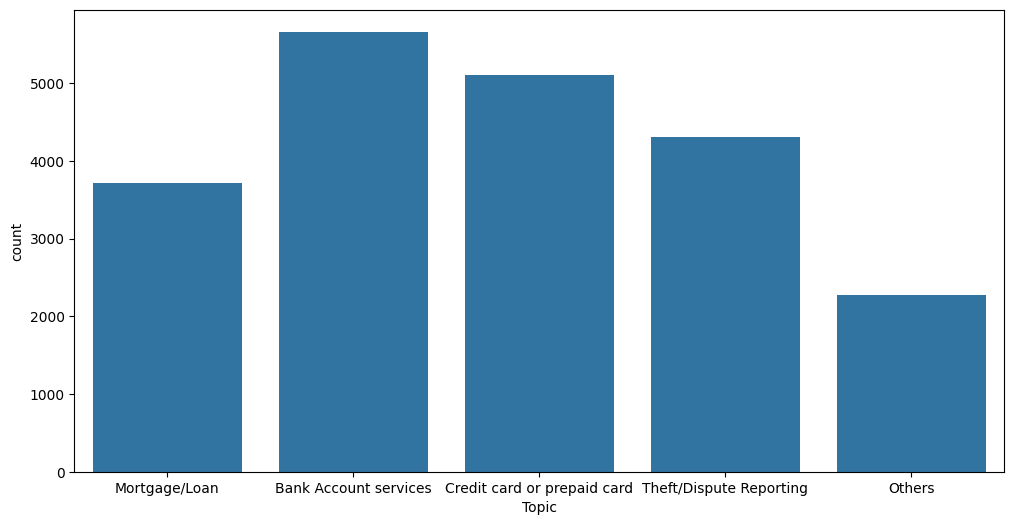

In [53]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=df_clean)

In [54]:
#columns with complaint_text & Topic

training_data = df_clean[['complaint_text','Topic']]

In [55]:
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,Bank Account services
10,chase card was reported on however fraudulent ...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,Bank Account services


In [56]:
## Reverse topic names mapping

reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i...,1
14,my grand son give me check for i deposit it in...,0


In [57]:
training_data[['complaint_text','Topic']][training_data.Topic==2].head(30)

,complaint_text,Topic
58,i made a purchase of on xxxxxxxx i made paymen...,2
82,i recently called to ask chase bank why they r...,2
141,action taken by the company between the dates ...,2
167,a double payment from my chase debt cart to ch...,2
212,on saturday xxxxxxxx and tuesday i used chase...,2
213,my mortgage is with chase my payments were bei...,2
267,i received an offer from chase xxxx visa promi...,2
287,i have a chase sapphire reserved card and the ...,2
294,spoke to the with payment arrangement xxxxxxxx...,2
296,claim number xxxx this complaint is in regard ...,2


**split data into X, y**

In [58]:
# x - y  split
X = training_data.complaint_text
y = training_data.Topic

In [59]:
# Fit transform the X
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)


**Train Test Split**

In [61]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

**Random Forest**

In [62]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay


**Custom Classification Report**

In [63]:

def display_classification_report(model,metric):

    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')

    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)

    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))

    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)

    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)

    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

**Custom GridSearchCV**

In [65]:
# utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):

    grid_search = GridSearchCV(model,
                                cv=folds,
                                param_grid=params,
                                scoring=scoring,
                                n_jobs=-1, verbose=1)
    return grid_search

In [66]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

**Random Forest Classification**

OOB SCORE : 0.8165021513540875
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.97
Train Accuracy : 1.0
Test Accuracy : 0.82
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      3828
           2       1.00      1.00      1.00      1708
           3       1.00      1.00      1.00      3235
           4       1.00      1.00      1.00      2786

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1416
           1       0.81      0.89      0.85      1276
           2       0.94      0.42      0.58       569
           3       0.83      0.81      0.82      1079
           4       0.86      0.81      0.83       

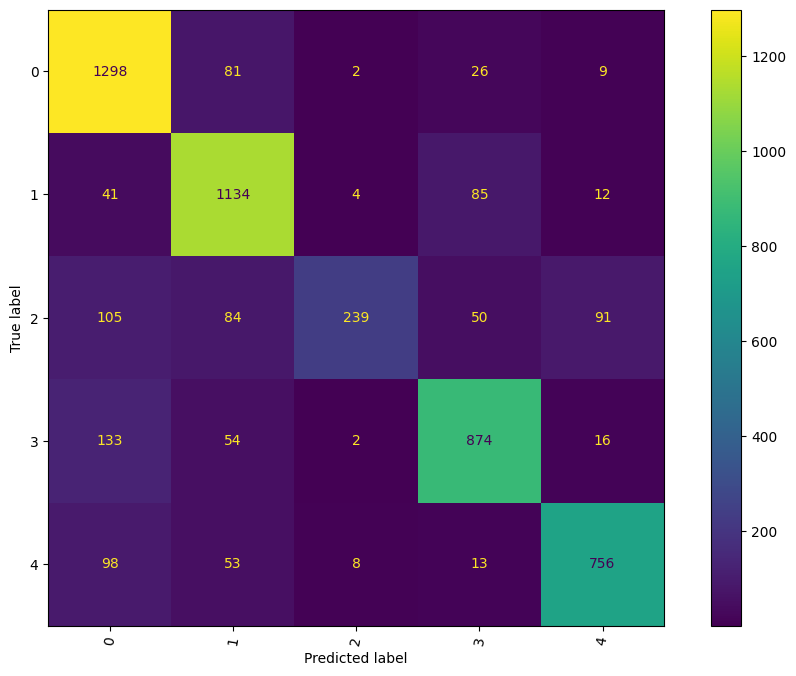

In [67]:
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_report(rf,metric4)

**Random Forest Classifier with GridSearchCV**

In [68]:
# Random Forest Classifier with GridSearchCV

rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30,40],
          'min_samples_leaf': [5,10,15,20,30],
          'n_estimators': [100,200,500,700]
        }

# create gridsearch object
grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')

# fit model
grid_search_rfc.fit(X_train, y_train)

# oob score
print('OOB SCORE :',grid_search_rfc.best_estimator_.oob_score_)

# print best hyperparameters
print_best_score_params(grid_search_rfc)

# Random Forest Classification Report
metric8=[]
display_classification_report(grid_search_rfc,metric8)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KeyboardInterrupt: 

**Model inference**


In [75]:
# raw complaint text
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [77]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [78]:
# predict
prediction=grid_search_rfc.predict(test_tfidf)
prediction

array([0])

In [79]:
topic_mapping[prediction[0]]

'Bank Account services'